### Import các thư viện cần thiết

In [34]:
from sklearn.model_selection import (train_test_split, cross_val_score, GridSearchCV)
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample, shuffle
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(561)
sns.set(rc={"figure.figsize":(10, 8)})

In [35]:
dataset = pd.read_csv("../clean-data/clean_data.csv")
dataset.head()

,TotalEmployees,TotalEmployeesIndia,Rating,CompanyType,Name,CompanyReviewsLive,CompanySalaries,InterviewExperiencesLive,Age,HQCountry,Headquarters,CompanyJobsLive,LocationCount,Industry
0,100001.0,100001.0,1,Public,Tata Consultancy Services,41589,394003,2783,54,India,Mumbai,55,240,"BPO / Call Centre,IT Services & Consulting"
1,100001.0,100001.0,2,Public,Accenture,27770,268685,2177,33,Ireland,Dublin,7294,132,"IT Services & Consulting,Software Product"
2,100001.0,100001.0,1,Private,Cognizant,25176,272214,1748,28,United States (USA),Teaneck,316,88,IT Services & Consulting
3,100001.0,100001.0,2,Public,ICICI Bank,32063,100049,940,28,India,Mumbai,150,995,"Financial Services,Banking"
4,100001.0,100001.0,1,Public,Wipro,23674,200635,1819,77,India,Bangalore/Bengaluru,520,254,IT Services & Consulting


In [36]:
print("Kích thước dataset : ", dataset.shape)

Kích thước dataset :  (9988, 14)


In [37]:
dataset.drop(dataset[dataset["Rating"] == 0].index, inplace=True)

In [38]:
print("Kích thước dataset : ", dataset.shape)


Kích thước dataset :  (9775, 14)


# Xử lý dữ liệu mất cân bằng trên toàn bộ dataset

In [18]:
# dataset_samples = len(dataset)

# rating_2 = dataset[dataset["Rating"] == 2]
# rating_3 = dataset[dataset["Rating"] == 3]
# rating_4 = dataset[dataset["Rating"] == 4]
# rating_5 = dataset[dataset["Rating"] == 5]
# print(len(rating_2), len(rating_3), len(rating_4), len(rating_5))

# rating_2 = resample(rating_2, replace=True, n_samples=int(0.05*dataset_samples))
# rating_3 = resample(rating_3, replace=True, n_samples=int(0.25*dataset_samples))
# rating_4 = resample(rating_4, replace=True, n_samples=int(0.55*dataset_samples))
# rating_5 = resample(rating_5, replace=True, n_samples=int(0.15*dataset_samples))
# print(len(rating_2), len(rating_3), len(rating_4), len(rating_5))

# dataset = pd.concat([rating_2, rating_3, rating_4, rating_5])
# # Xáo trộn ngẫu nhiên lại dataset
# dataset = shuffle(dataset)

# plt.figure(figsize=(4, 4))
# sns.countplot(data=dataset, x="Rating")
# plt.xlabel("Rating")
# plt.ylabel("Số lượng")

## Chia dữ liệu Train / Test

Chia theo tỉ lệ 20/80, stratify theo Potability để tỉ lệ nước uống được/không uống được bằng nhau ở 2 tập train và test

In [39]:
X_columns = ["TotalEmployees", "TotalEmployeesIndia", "CompanyReviewsLive", "CompanySalaries", 
             "InterviewExperiencesLive", "Age", "CompanyJobsLive", "LocationCount"]
Y_columns = "Rating"

X_train, X_test, Y_train, Y_test = train_test_split(dataset[X_columns].fillna(0),
                                                    dataset[Y_columns],
                                                    test_size=0.2, 
                                                    stratify=dataset[Y_columns],
                                                    random_state=42)

X_train.shape, X_test.shape

((7820, 8), (1955, 8))

Tỉ lệ nước uống được/không uống được ở 2 tập train và test

<AxesSubplot:ylabel='Rating'>

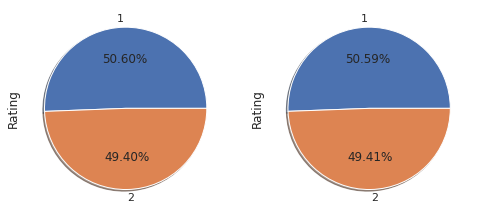

In [40]:
plt.subplot(1, 2, 1)
Y_train.value_counts().plot.pie(figsize=(8, 8), shadow=True, autopct='%1.2f%%')

plt.subplot(1, 2, 2)
Y_test.value_counts().plot.pie(figsize=(8, 8), shadow=True, autopct='%1.2f%%')

## Xử lý dữ liệu mất cân bằng trên tập Train

In [21]:
# # Tạm gộp X và Y lại
# train_dataset = X_train.copy()
# train_dataset["Rating"]=Y_train
# train_dataset_samples = len(train_dataset)

# rating_2 = train_dataset[train_dataset["Rating"] == 2]
# rating_3 = train_dataset[train_dataset["Rating"] == 3]
# rating_4 = train_dataset[train_dataset["Rating"] == 4]
# rating_5 = train_dataset[train_dataset["Rating"] == 5]
# print(len(rating_2), len(rating_3), len(rating_4), len(rating_5))

# rating_2 = resample(rating_2, replace=True, n_samples=int(0.05*train_dataset_samples))
# rating_3 = resample(rating_3, replace=True, n_samples=int(0.25*train_dataset_samples))
# rating_4 = resample(rating_4, replace=True, n_samples=int(0.55*train_dataset_samples))
# rating_5 = resample(rating_5, replace=True, n_samples=int(0.15*train_dataset_samples))
# print(len(rating_2), len(rating_3), len(rating_4), len(rating_5))

# train_dataset = pd.concat([rating_2, rating_3, rating_4, rating_5])
# # Xáo trộn ngẫu nhiên lại train_dataset
# train_dataset = shuffle(train_dataset)

# # Lấy lại X và Y
# X_train = train_dataset[X_columns]
# Y_train = train_dataset[Y_columns]

# plt.figure(figsize=(4, 4))
# sns.countplot(data=train_dataset, x="Rating")
# plt.xlabel("Rating")
# plt.ylabel("Số lượng")

## Xử lý Outlier cho tập Train, tập Test giữ nguyên Outlier : 

In [22]:
# def Remove_Outlier(dataset):
#     data = dataset.copy()
#     for col in data.columns:
#         lower_boundary = round(data[col].mean() - 3* data[col].std())
#         upper_boundary = round(data[col].mean() + 3 * data[col].std())
#         data.loc[data[col] <= lower_boundary, col] = lower_boundary
#         data.loc[data[col] >= upper_boundary, col] = upper_boundary
#     return data

In [23]:
# # Tập X_train gốc có xử lý ngoại lệ
# X_train_outlier = Remove_Outlier(X_train)
# X_train_outlier.shape

## Chuẩn hóa Z-score

Áp dụng chuẩn hóa bằng cách fit cho tập Train và dùng bộ tham số đó để transform cho cả tập Train và Test 

In [41]:
X_test_outlier = X_test.copy()

# Chuẩn hóa tập Train gốc
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
# Sử dụng lại chính scaler của tập Train để chuẩn hóa cho tập Test
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Chuẩn hóa tập Train gốc có xử lý ngoại lệ
# scaler = StandardScaler()
# scaler.fit(X_train_outlier)
# X_train_outlier = pd.DataFrame(scaler.transform(X_train_outlier), columns=X_train_outlier.columns)
# X_test_outlier = pd.DataFrame(scaler.transform(X_test_outlier), columns=X_test_outlier.columns)

## Hyperparameter Tuning

Hàm format độ chính xác về %

In [42]:
def acc(accuracy):
    return f"{round(accuracy*100, 2)} (%)"

Tìm kiếm các siêu tham số tốt nhất cho mô hình bằng tập Train, đồng thời đánh giá độ chính xác thu được khi áp dụng cho tập Test

In [43]:
def hyperparameter_tuning_rfc(XTrain, YTrain, XTest, YTest):
    random_forest = RandomForestClassifier(random_state=42)
    # params = {
    #     "n_estimators": [100, 200, 300, 400], 
    #     "min_samples_leaf": [1, 2, 10]
    # }
    params = {
        "n_estimators": [100, 200,300,400],
        "min_samples_leaf": [1, 2, 10]
    }
    search = GridSearchCV(estimator=random_forest, param_grid=params, cv=5, n_jobs=-1)
    search.fit(XTrain, YTrain)
    # Kết quả Tuning tốt nhất
    print(f"Best : {acc(search.best_score_)} using {search.best_params_}")
    print(f"Test set : {acc(search.score(XTest, YTest))}")
    return search.best_params_


print(">> X_train gốc : ")
best_params_1 = hyperparameter_tuning_rfc(X_train, Y_train, X_test, Y_test)
# print(">> X_train gốc có xử lý ngoại lệ : ")
# best_params_2 = hyperparameter_tuning_rfc(X_train_outlier, Y_train, X_test_outlier, Y_test)

>> X_train gốc : 
Best : 65.68 (%) using {'min_samples_leaf': 1, 'n_estimators': 400}
Test set : 66.04 (%)


0.6603580562659846


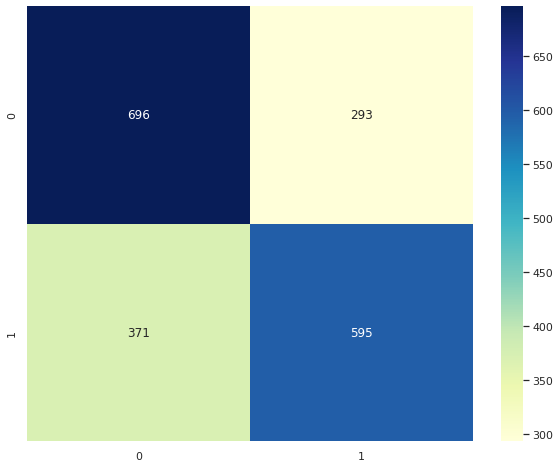

In [44]:
def RF_Model(XTrain, YTrain, XTest, YTest,best_params):
    random_forest = RandomForestClassifier(n_estimators=best_params["n_estimators"],
                                           min_samples_leaf=best_params["min_samples_leaf"],
                                           random_state=42)
    random_forest.fit(XTrain,YTrain)
    Y_pred = random_forest.predict(XTest)
    sns.heatmap(confusion_matrix(YTest, Y_pred), cmap="YlGnBu", annot=True, fmt='g')
    print(accuracy_score(YTest,Y_pred))


RF_Model(X_train, Y_train, X_test, Y_test, best_params_1)


# SVM

In [45]:
def hyperparameter_tuning_svm(XTrain, YTrain, XTest, YTest):
    svm_model = SVC()
    params = {
        'C': [0.1,1,10],
        'gamma': ['scale','auto'],
        'kernel': ['rbf','linear']
    }
    search = GridSearchCV(estimator=svm_model, param_grid=params, cv=5, n_jobs=-1)
    search.fit(XTrain, YTrain)
    # Kết quả Tuning tốt nhất
    print(f"Best : {acc(search.best_score_)} using {search.best_params_}")
    print(f"Test set : {acc(search.score(XTest, YTest))}")
    return search.best_params_


print(">> X_train gốc : ")
best_params_1 = hyperparameter_tuning_svm(X_train, Y_train, X_test, Y_test)
# print(">> X_train gốc có xử lý ngoại lệ : ")
# best_params_2 = hyperparameter_tuning_svm(X_train_outlier, Y_train, X_test_outlier, Y_test)

>> X_train gốc : 
Best : 59.48 (%) using {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Test set : 61.74 (%)


0.6173913043478261


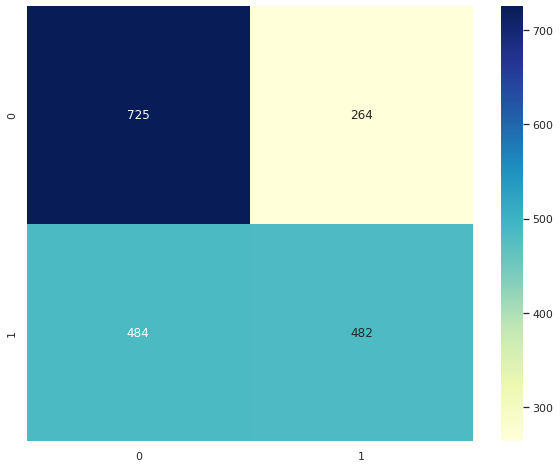

In [46]:
def SVM_Model(XTrain, YTrain, XTest, YTest, best_params):
    svm_model = SVC(C=best_params["C"],
                    gamma=best_params["gamma"],
                    kernel=best_params["kernel"])
    svm_model.fit(XTrain, YTrain)
    Y_pred = svm_model.predict(XTest)
    sns.heatmap(confusion_matrix(YTest, Y_pred), cmap="YlGnBu", annot=True, fmt='g')
    print(accuracy_score(YTest, Y_pred))


SVM_Model(X_train, Y_train, X_test, Y_test, best_params_1)


## Huấn luyện lại Model trên toàn bộ dữ liệu ở 4 trường hợp

In [ ]:
# def cross_val_model(X, Y, best_params):
#     model = RandomForestClassifier(
#         n_estimators=best_params["n_estimators"],
#         min_samples_leaf=best_params["min_samples_leaf"],
#         random_state=42)
#     scores = cross_val_score(model, X, Y, cv=5)
#     print(acc(np.mean(scores)))


# print(">> X_train gốc : ")
# cross_val_model(pd.concat([X_train, X_test]), pd.concat([Y_train, Y_test]), best_params_1)
# print(">> X_train gốc có xử lý ngoại lệ : ")
# cross_val_model(pd.concat([X_train_outlier, X_test_outlier]), pd.concat([Y_train, Y_test]), best_params_2)
